In [10]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy,SOPStrategy,DYCORSStrategy
from pySOT.optimization_problems import Rosenbrock
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [45]:
class Lm_rosenbrock(Rosenbrock):
    """Rosenbrock function

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self, dim=10,ep = 1):
        self.ep = ep
        self.dim = dim
        #self.c = self.eval(np.random.random(size = self.dim))
        self.c = 1
        self.H_ys = []
        self.beta = 1/ep
        self.min = 0
        self.minimum = np.ones(dim)
        self.lb = -2.048 * np.ones(dim)
        self.ub = 2.048 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional Rosenbrock function \n" + "Global optimum: f(1,1,...,1) = 0"

        # linear f
    def eval1(self, x):
        """Evaluate the modified Rosenbrock function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


In [16]:
def ex_helper(times):
    max_evals = 300
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_rosenbrock = Rosenbrock(dim=10)
        rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
        slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))
        controller1 = SerialController(objective=lm_rosenbrock.eval)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [17]:
l2 = ex_helper(30)

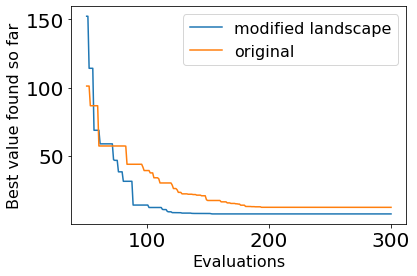

7.614494236706329 12.425069906694292


(7.614494236706329, 12.425069906694292)

In [50]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/plots'

  
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 500
    
    lm_rosenbrock = Lm_rosenbrock(dim=10)
    rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
    slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_rosenbrock.eval1)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
    # Run the optimization strategy
    result = controller.run()
    l1 = lm_rosenbrock.H_ys

    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[50:300],fvals2[50:300]]:
        plt.errorbar(np.arange(start = 50, stop = 300)+1, y=results)

    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    #plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
     #         format(lm_rosenbrock.eval(result.params[0]),min(l2[:,i])),
      #        fontsize = 18)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 100)
    plt.show()

    print(lm_rosenbrock.eval(result.params[0]),min(l2[:,i]))
    return lm_rosenbrock.eval(result.params[0]),min(l2[:,i])
    


example_simple(3,path,3,l2)


In [43]:

def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('rosenbrock, square landscape modification, adaptive c')
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('standard deviation of landscape modified is {}'.format(np.std(lm_list)))
    print('standard deviation of non landscape modified is {}'.format(np.std(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best result of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst result of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

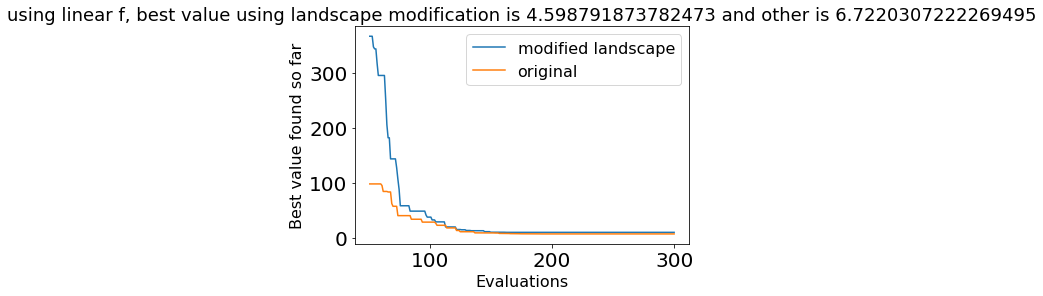

4.598791873782473 6.7220307222269495


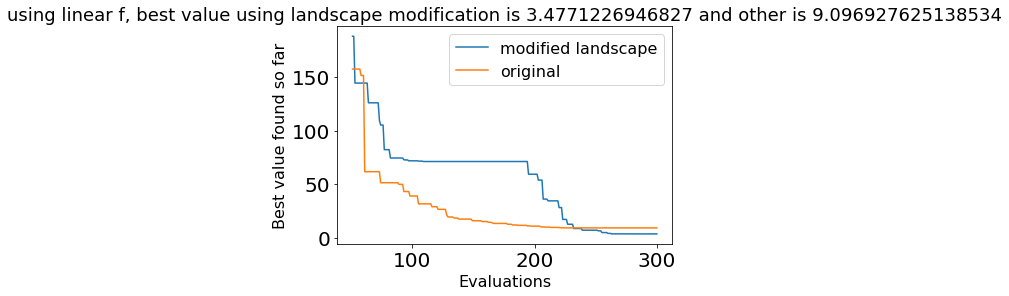

3.4771226946827 9.096927625138534


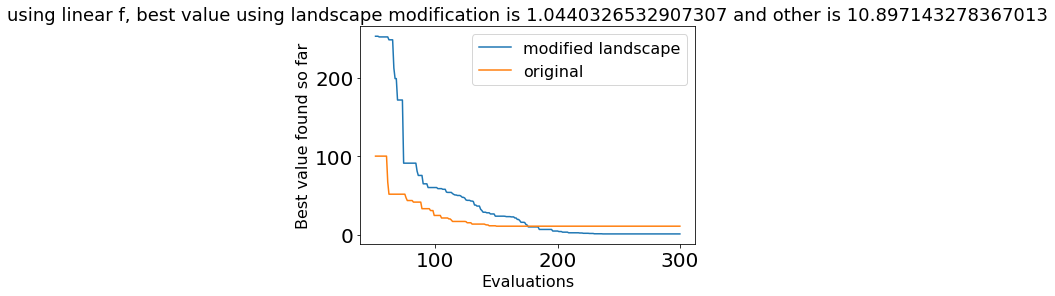

1.0440326532907307 10.897143278367013


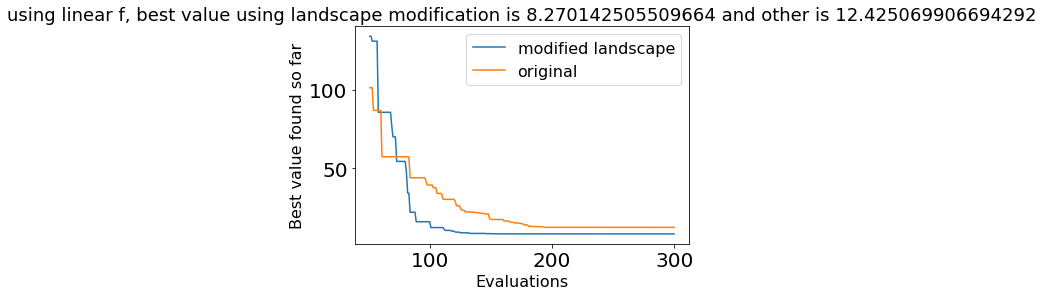

8.270142505509664 12.425069906694292


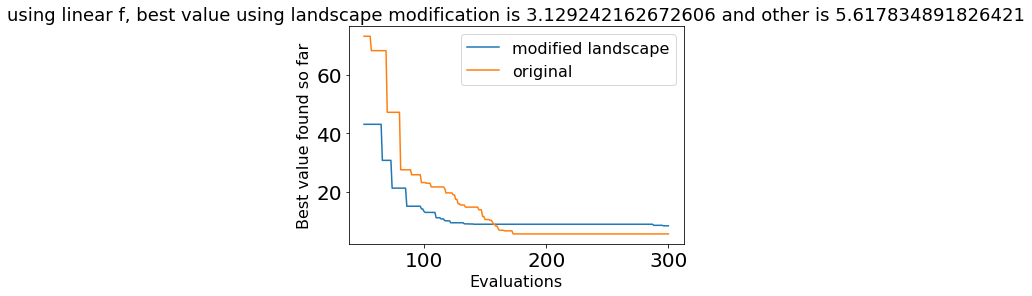

3.129242162672606 5.617834891826421


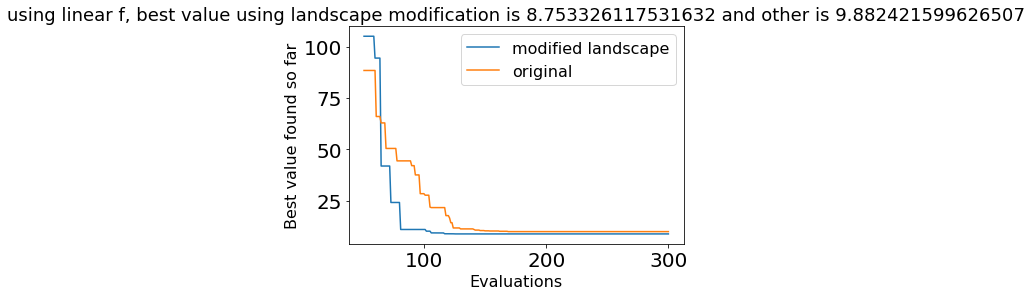

8.753326117531632 9.882421599626507


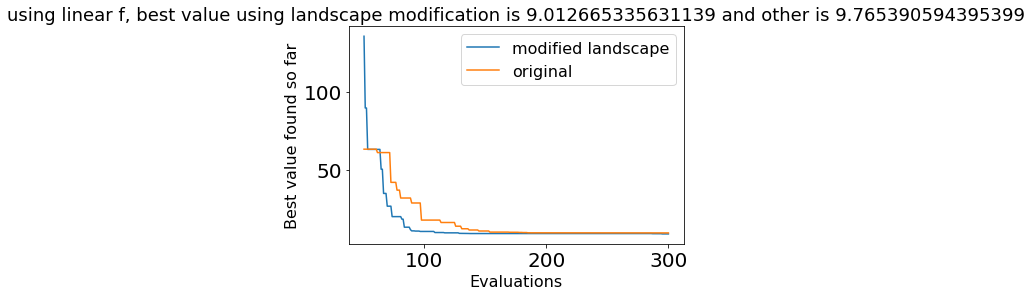

9.012665335631139 9.765390594395399


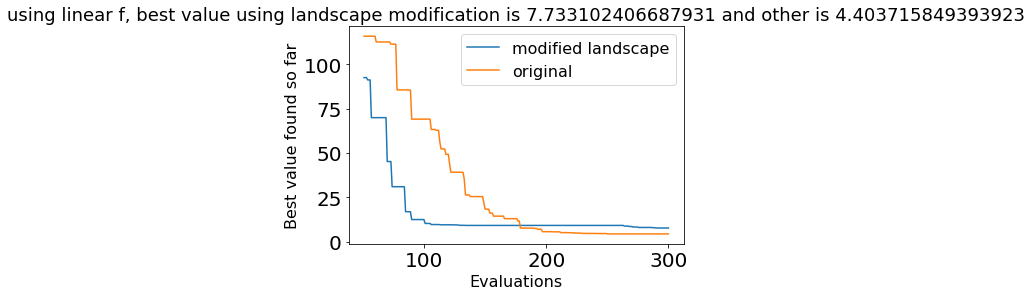

7.733102406687931 4.403715849393923


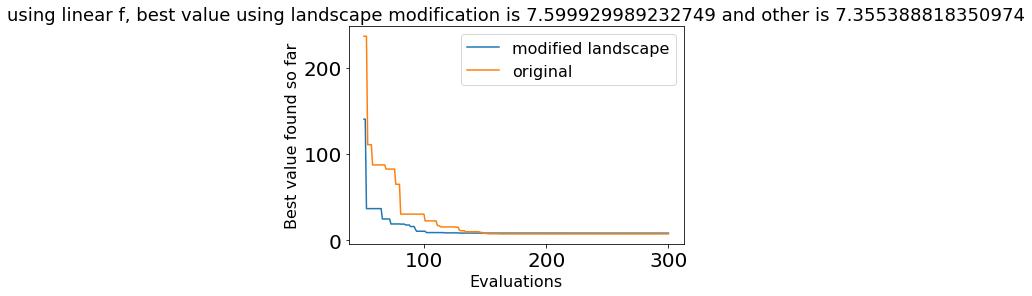

7.599929989232749 7.355388818350974


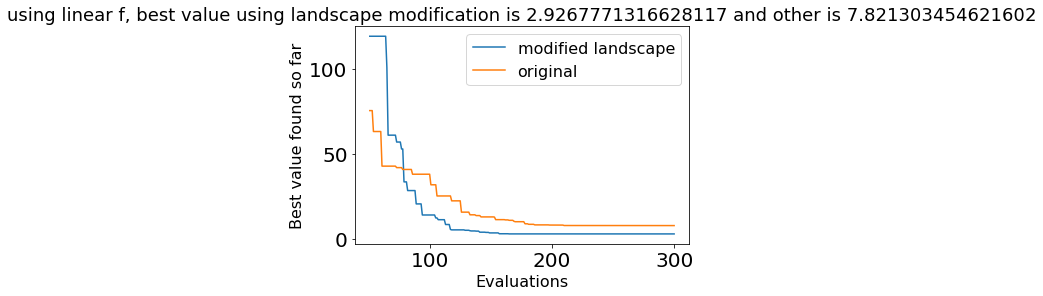

2.9267771316628117 7.821303454621602


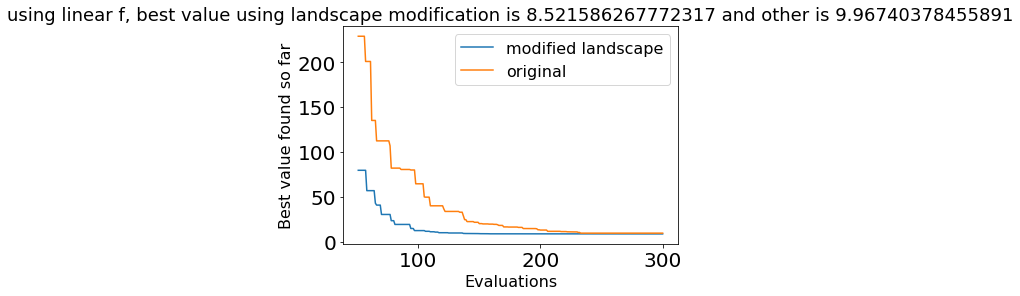

8.521586267772317 9.96740378455891


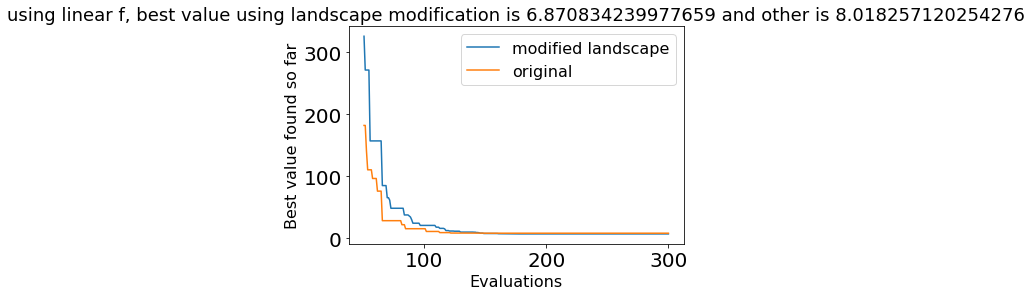

6.870834239977659 8.018257120254276


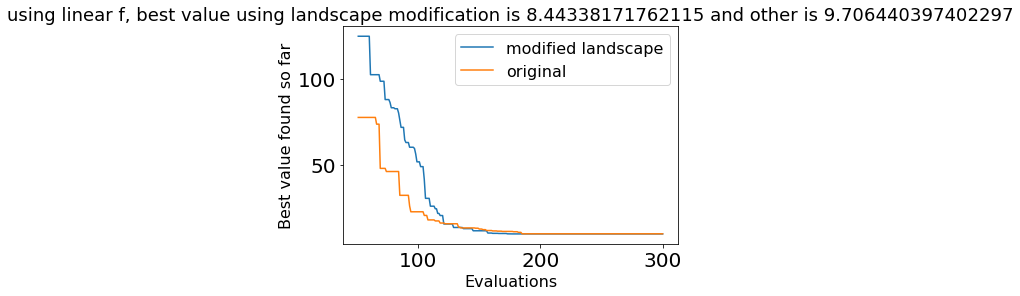

8.44338171762115 9.706440397402297


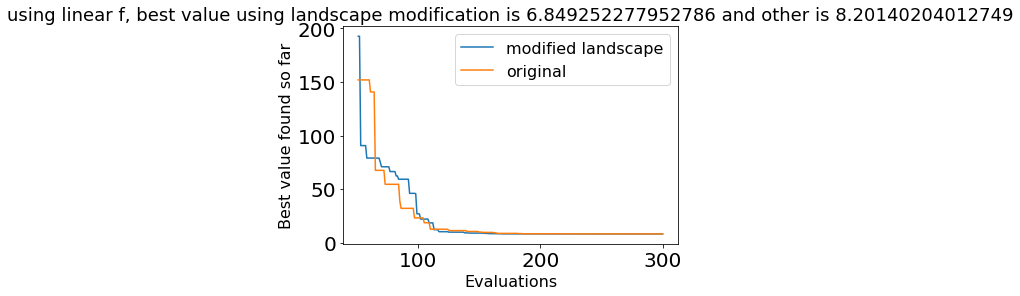

6.849252277952786 8.20140204012749


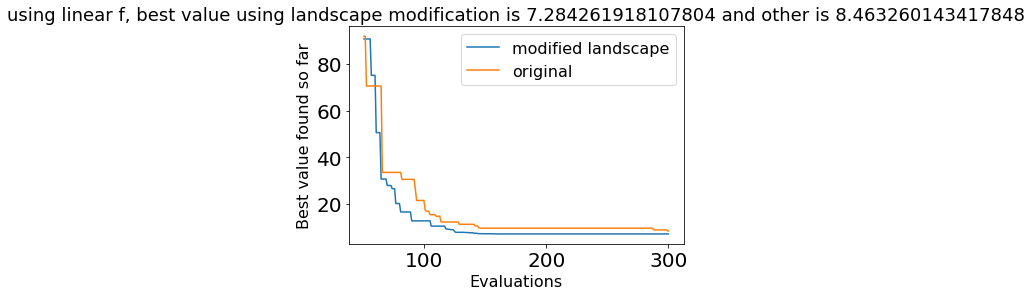

7.284261918107804 8.463260143417848


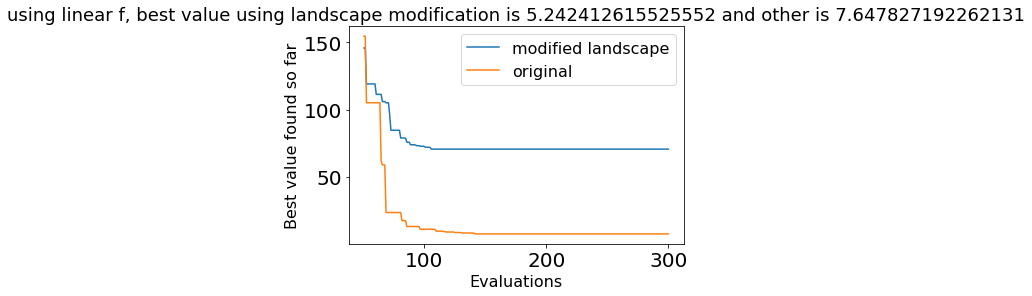

5.242412615525552 7.647827192262131


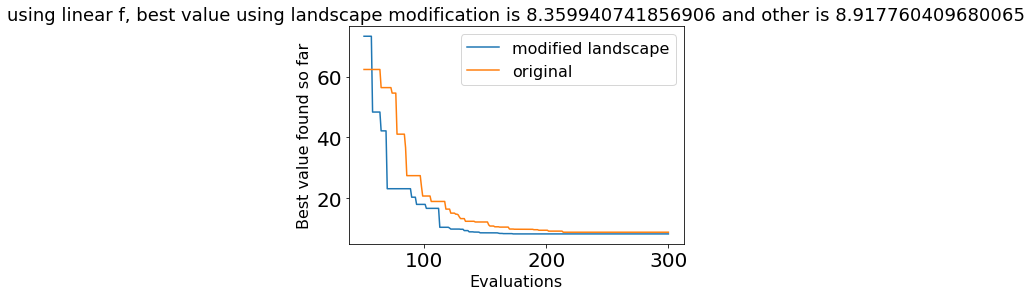

8.359940741856906 8.917760409680065


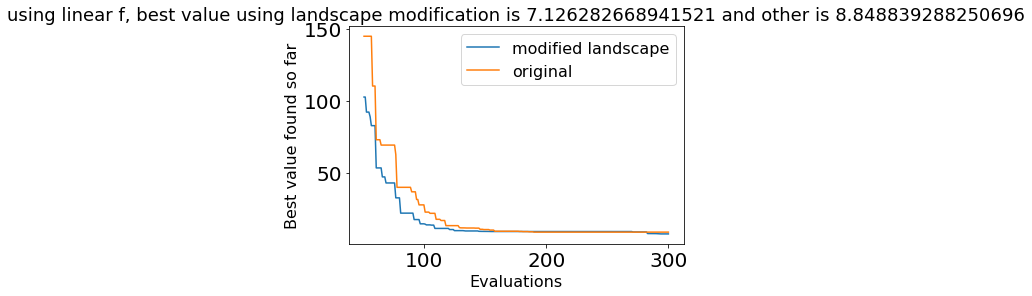

7.126282668941521 8.848839288250696


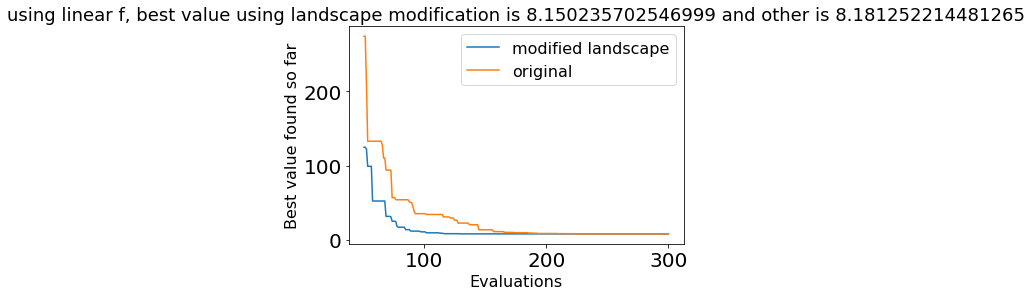

8.150235702546999 8.181252214481265


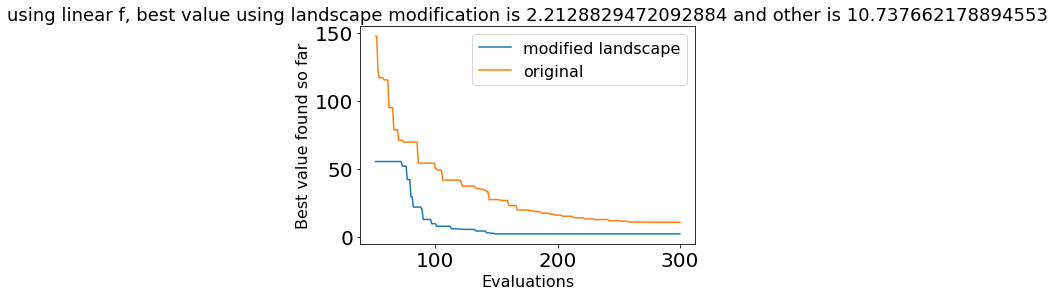

2.2128829472092884 10.737662178894553


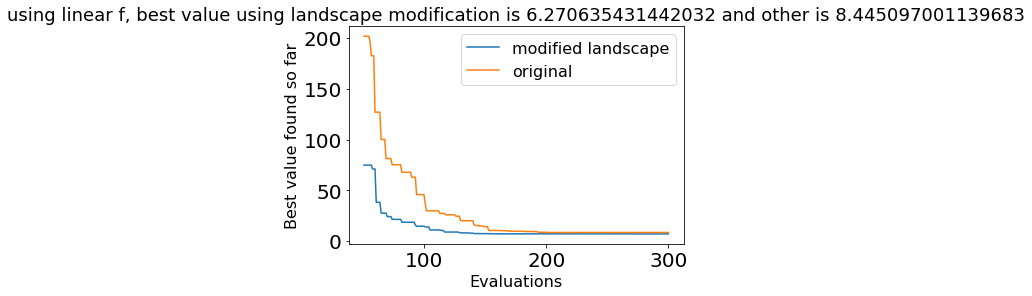

6.270635431442032 8.445097001139683


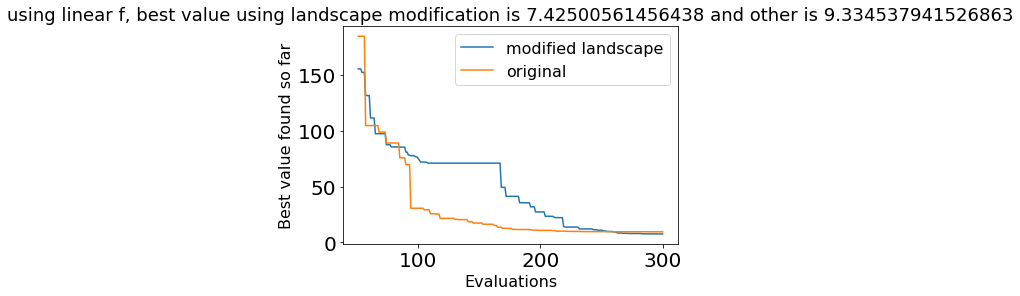

7.42500561456438 9.334537941526863


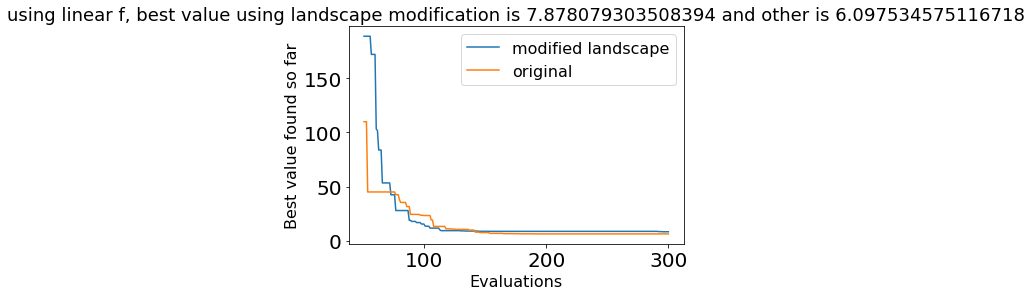

7.878079303508394 6.097534575116718


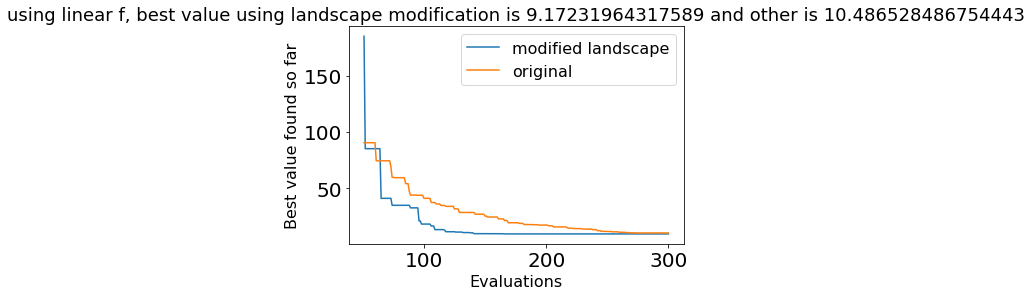

9.17231964317589 10.486528486754443


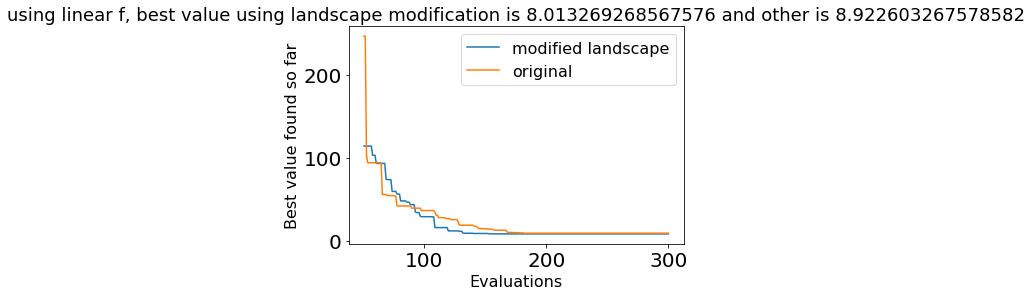

8.013269268567576 8.922603267578582


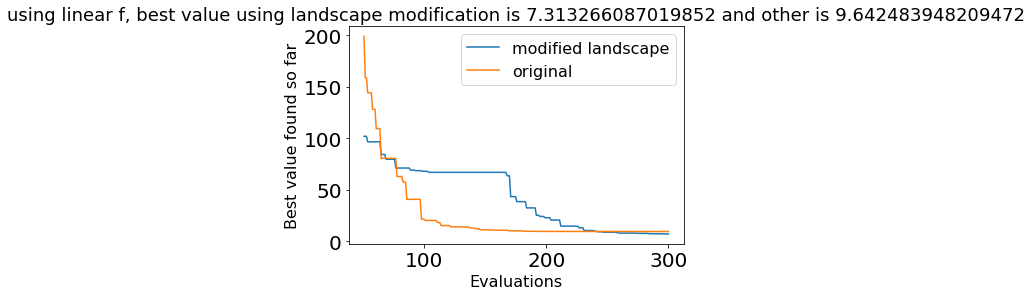

7.313266087019852 9.642483948209472


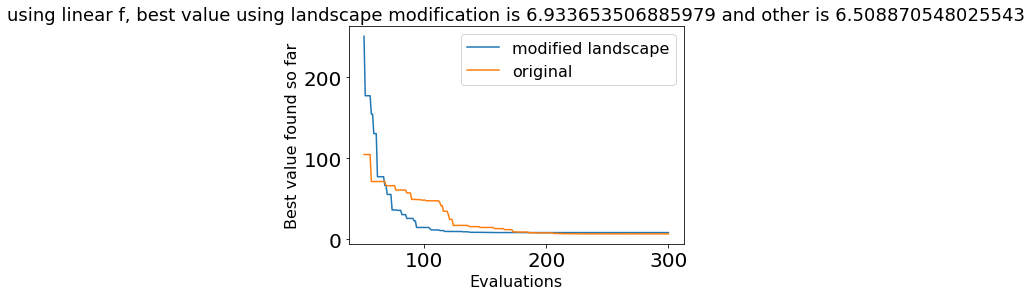

6.933653506885979 6.508870548025543


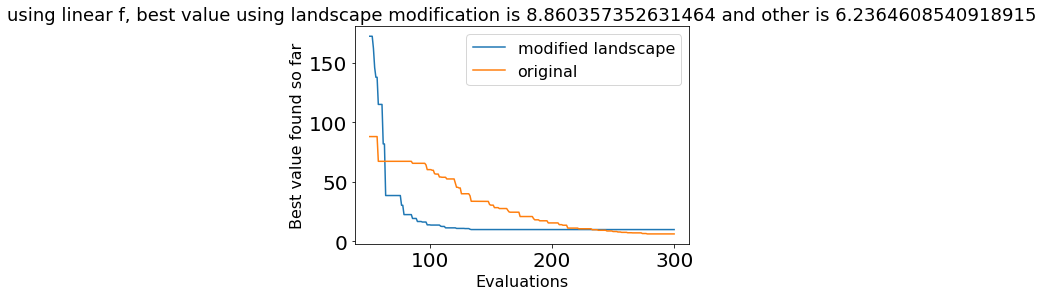

8.860357352631464 6.2364608540918915


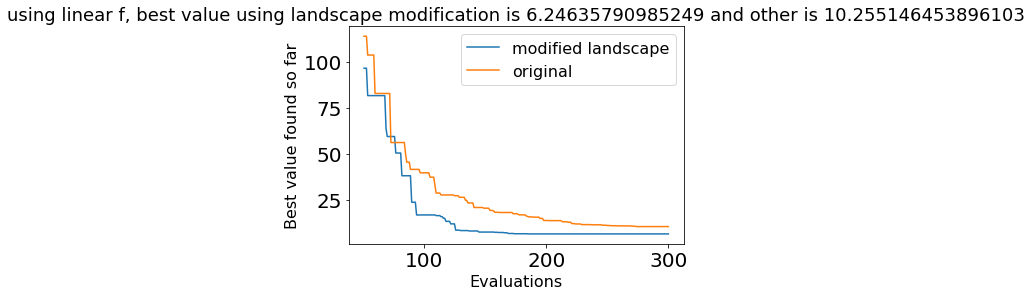

6.24635790985249 10.255146453896103


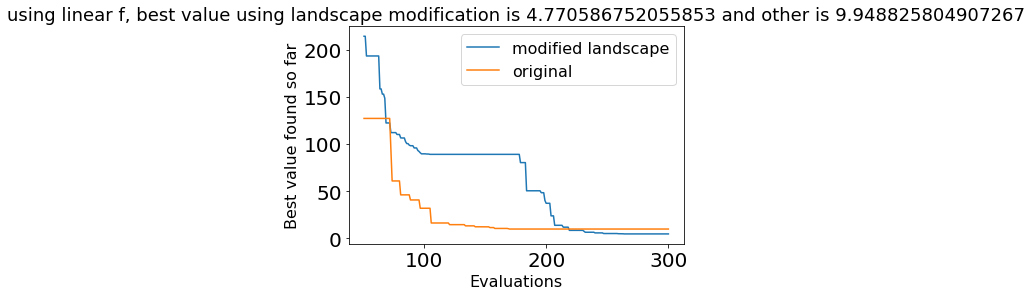

4.770586752055853 9.948825804907267
rosenbrock, square landscape modification, adaptive c
landscape modified was better 25 times and was worse 5 times
mean of landscape modified is 6.616324494596678
mean of non landscape modified is 8.61851401304059
median of landscape modified is 7.2987640025638285
median of non landscape modified is 8.88329984896538
standard deviation of landscape modified is 2.164002214536711
standard deviation of non landscape modified is 1.7402097207270533
best result of landscape modified is 1.0440326532907307
best result of non landscape modified is 4.403715849393923
worst result of landscape modified is 9.17231964317589
worst result of non landscape modified is 12.425069906694292


([4.598791873782473,
  3.4771226946827,
  1.0440326532907307,
  8.270142505509664,
  3.129242162672606,
  8.753326117531632,
  9.012665335631139,
  7.733102406687931,
  7.599929989232749,
  2.9267771316628117,
  8.521586267772317,
  6.870834239977659,
  8.44338171762115,
  6.849252277952786,
  7.284261918107804,
  5.242412615525552,
  8.359940741856906,
  7.126282668941521,
  8.150235702546999,
  2.2128829472092884,
  6.270635431442032,
  7.42500561456438,
  7.878079303508394,
  9.17231964317589,
  8.013269268567576,
  7.313266087019852,
  6.933653506885979,
  8.860357352631464,
  6.24635790985249,
  4.770586752055853],
 [6.7220307222269495,
  9.096927625138534,
  10.897143278367013,
  12.425069906694292,
  5.617834891826421,
  9.882421599626507,
  9.765390594395399,
  4.403715849393923,
  7.355388818350974,
  7.821303454621602,
  9.96740378455891,
  8.018257120254276,
  9.706440397402297,
  8.20140204012749,
  8.463260143417848,
  7.647827192262131,
  8.917760409680065,
  8.8488392882

In [44]:
checker(30,path,l2)